<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/04%20investment%20portfolios%20with%20DCF.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

You can run the code examples in [Google Colab](https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/03%20investment%20portfolios.ipynb).

**To install the package:**

In [35]:
!pip install okama

import okama and matplotlib packages ...

In [36]:
import warnings

import matplotlib.pyplot as plt

import okama as ok

plt.rcParams["figure.figsize"] = [12.0, 6.0]
warnings.simplefilter(action="ignore", category=FutureWarning)

Сlass **Portfolio** can be used to define the basic investment strategy (without cash flow).

In [38]:
pf = ok.Portfolio(
    ["SPY.US", "AGG.US", "GLD.US"],
    weights=[0.60, 0.35, 0.05],
    ccy="USD",
    inflation=True,
    last_date="2024-01",
    rebalancing_period="year",
    symbol="My_portfolio.PF"
)
pf

symbol                         My_portfolio.PF
assets                [SPY.US, AGG.US, GLD.US]
weights                      [0.6, 0.35, 0.05]
rebalancing_period                        year
currency                                   USD
inflation                             USD.INFL
first_date                             2004-12
last_date                              2024-01
period_length               19 years, 2 months
dtype: object

## Set up Cash Flow strategy

Cash flow parameters for investment portfolios can be configured in the corresponding classes:

- `IndexationStrategy` for strategies with regular indexed withdrawals / contributions
- `PercentageStrategy` for strategies weith regualr fixed percentage withdrawals / contributions
- `TimeSeriesStrategy` for strategies with user-defined withdrawals and contributions. Withdrawals, contributions, as well as their dates, are defined in the dictionary.

## IndexationStrategy: regular indexed withdrawals or contributions

`IndexationStrategy` class can be used to set up a cash flow strategy where contributions or withdrawals to portfolio are made with a certain frequency.  All contributions can be indexed each period.

In [39]:
ind = ok.IndexationStrategy(pf) # create IndexationStrategy linked to the Portfolio

Set up the cash flow parameters.

In [40]:
ind.initial_investment = 10_000  # the initial investments size
ind.amount = -2_500  # set withdrawal size
ind.frequency = "year"  # set cash flow frequency
ind.indexation = "inflation"  # set indexation equal to mean inflation
ind

Portfolio symbol                My_portfolio.PF
Cash flow initial investment              10000
Cash flow frequency                        year
Cash flow strategy                 fixed_amount
Cash flow amount                          -2500
Cash flow indexation                   0.025322
dtype: object

Assign the strategy to Portfolio.

In [41]:
pf.dcf.cashflow_parameters = ind  # assign the cash flow strategy to portfolio

### Backtest the Portfolio with cash flow

We can start by verifying the strategy on historical data. 

<Axes: xlabel='date'>

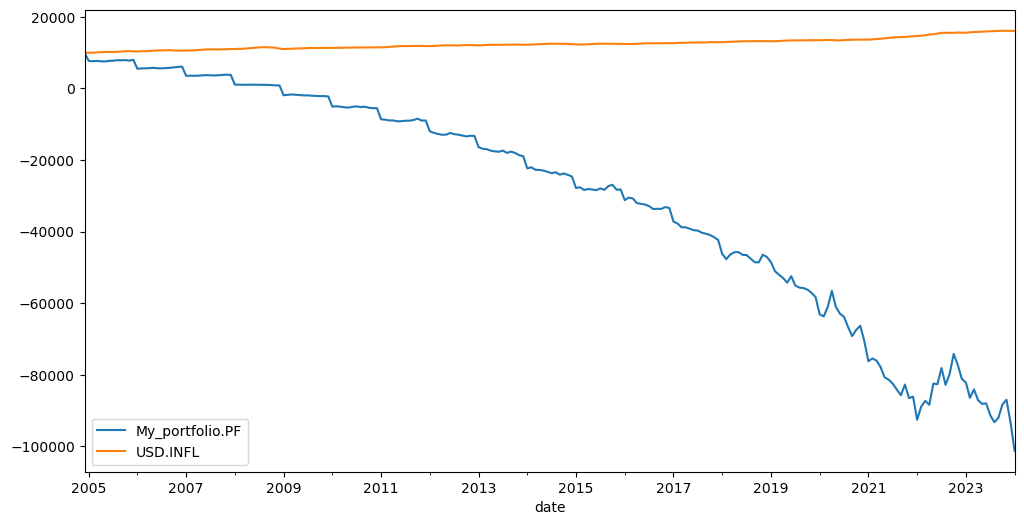

In [42]:
pf.dcf.wealth_index.plot()

It's easy to see that the portfolio balance is voided fast. The "survival period" is 4.2 years. The withdrawal size is too big.

In [43]:
pf.dcf.survival_period_hist()

4.2

To get the date of when the portfolio balance reduced to 0 we can use `survival_date_hist()`

In [44]:
pf.dcf.survival_date_hist()

Timestamp('2009-01-31 00:00:00')

Let's change the withdrawal size...

In [45]:
pf.dcf.cashflow_parameters.amount = -600

<Axes: xlabel='date'>

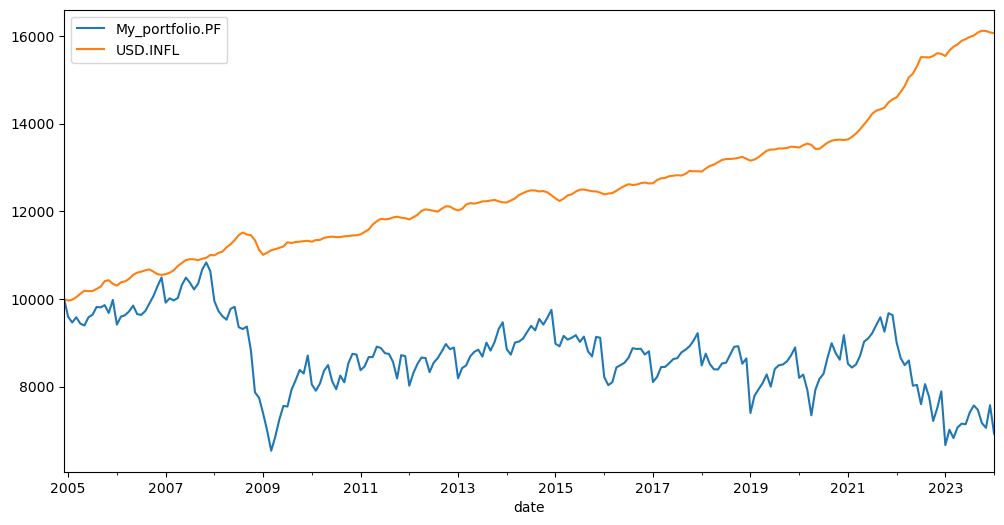

In [46]:
pf.dcf.wealth_index.plot()

With new withdrawal size the portfolio successfully pass backtesting even though the balance is below the inflation. 

The size of the initial investment in 2004 (the beginning of the historical data period) is 10,000. However, the purchasing power of money 20 years ago was different.   
It depends on `discount_rate` parameter.

In [47]:
pf.dcf.discount_rate = 0.07  # set discount rate to 7%

If not defined, the `discount_rate` is the inflation rate or (if there is not inflation data) the discount default value - 5%.

The discounted size of the initial investment can be found with `initial_investment_pv`:

In [48]:
pf.dcf.initial_investment_pv

2746.4382960214607

If we want to start backtesting a strategy with a discounted initial investment and withdrawal amount, then it is enough to change the value of the `use_discounted_values` parameter.

In [49]:
pf.dcf.use_discounted_values = True

<Axes: xlabel='date'>

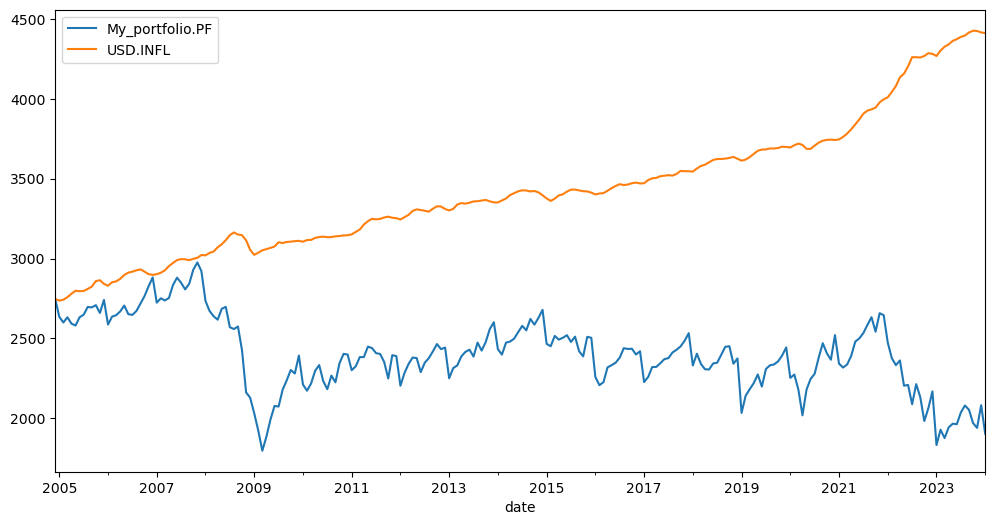

In [50]:
pf.dcf.wealth_index.plot()

When the withdrawal size -500 (5% of the initial investments) the portfolio balance lasts for all 19 years of backtest period. But will it work in the future? Is it an optimal withdrawal size?

To answer these questions, we can use Monte Carlo simulation. This will help testing the strategy on multiple scenarios (not just one, as in a backtest).

### Monte Carlo simulation

First we need to set up Monte Carlo simulation parameters:

In [51]:
pf.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution) 
    period=60,  # the forecasting period is 10 years
    number=200  # generate 200 random simulations
)

in this case we use popular normal distribution to generate random rate of return series in Monte Carlo scenarios. However, there are other distribution types. How to backtest and select optimal distribution we discuss in [08 backtesting distribution.ipynb](https://github.com/mbk-dev/okama/blob/master/examples/08%20backtesting%20distribution.ipynb).

With Monte Carlo parameters we can test the future outcomes.

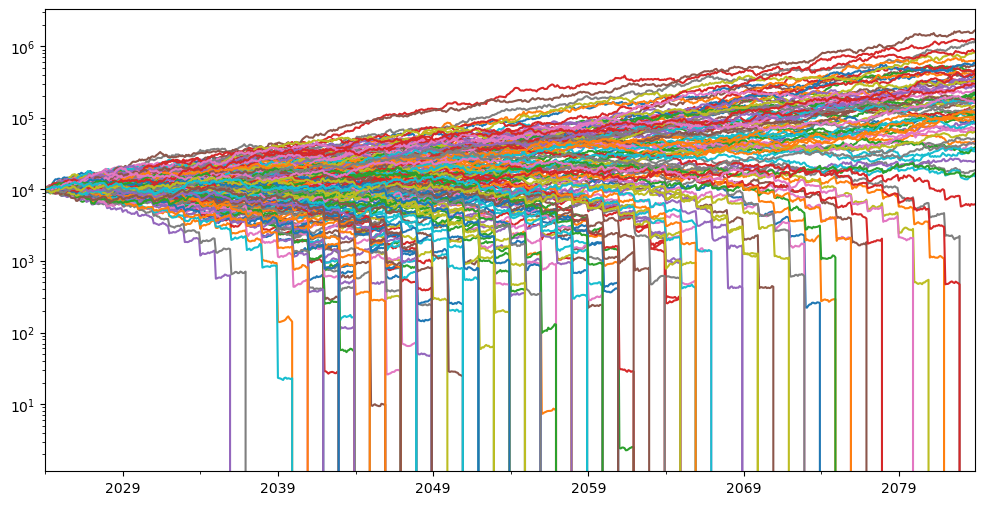

In [52]:
pf.dcf.plot_forecast_monte_carlo(backtest=False)
plt.yscale("log")  # set logarithmic scale for Y-axis to see negative scenarios 

We see in the chart that many scenarios were optimistic (portfolio balance was positive even after 60 years), and some other were negative (the portfolio balance is voided). 

With `monte_carlo_survival_period` we can get more statistical details about survival period.

In [53]:
s = pf.dcf.monte_carlo_survival_period()  # get all survival periods for random scenarios for our settings
s

0      21.1
1      22.1
2      60.0
3      60.0
4      60.0
       ... 
195    28.1
196    58.1
197    36.1
198    36.1
199    44.1
Length: 200, dtype: float64

In [54]:
s.min()  # the worst survival period from generated scenarios

np.float64(12.1)

In [55]:
s.quantile(5 / 100)  # survival period for worst 5% of scenarios (5th percentile)

np.float64(18.1)

In [56]:
s.quantile(25 / 100)  # survival period for worst 25% of scenarios (25th percentile)

np.float64(26.1)

In [57]:
s.quantile(50 / 100)  # survival period for median (50th percentile)

np.float64(40.1)

`find_the_largest_withdrawals_size()` method helps to find the largest withdrawal size for a cash flow strategy. 

*WARNING: this method can be slow for large Monte Carlo scenarios and `withdrawal_steps` number.*

In [58]:
pf.dcf.find_the_largest_withdrawals_size(
    withdrawal_steps=20,   # The number of intermediate steps during the iteration of values fom max to min of the withdrawal size
    confidence_level=0.25,  # Confidence level defines the percentile of Monte Carlo time series. The 25th percentile is a negative scenario.
    goal="survival_period",  # The goal of the strategy in this case is to keep the portfolio alive for a given survival period
    target_survival_period=30,  # the target period when the portfolio balance is not voided by withdrawals and market volatility
    threshold=0  # The percentage of initial investments when the portfolio balance is considered voided.
)

np.float64(-526.3157894736851)

## PercentageStrategy: regular fixed percentage withdrawals or contributions

In fixed percentage cash flow strategy withdrawals or contributions are a percentage of balance each period. Many know "4% rule" for withdrawals. But in this case we can test with any percentage.

In [59]:
pc = ok.PercentageStrategy(pf)  # create PercentageStrategy linked to the portfolio

In [60]:
pc.initial_investment = 10_000  # initial investments size
pc.frequency = "year"  # withdrawals frequency
pc.percentage = -0.12  # the percentage of withdrawals is 12%
pc

Portfolio symbol                 My_portfolio.PF
Cash flow initial investment               10000
Cash flow frequency                         year
Cash flow strategy              fixed_percentage
Cash flow percentage                       -0.12
dtype: object

In [61]:
pf.dcf.cashflow_parameters = pc  # assign the cash flow strategy to portfolio

12% is much more than recomended 4%. Let's check if this strategy "survive" backtesting.

<Axes: xlabel='date'>

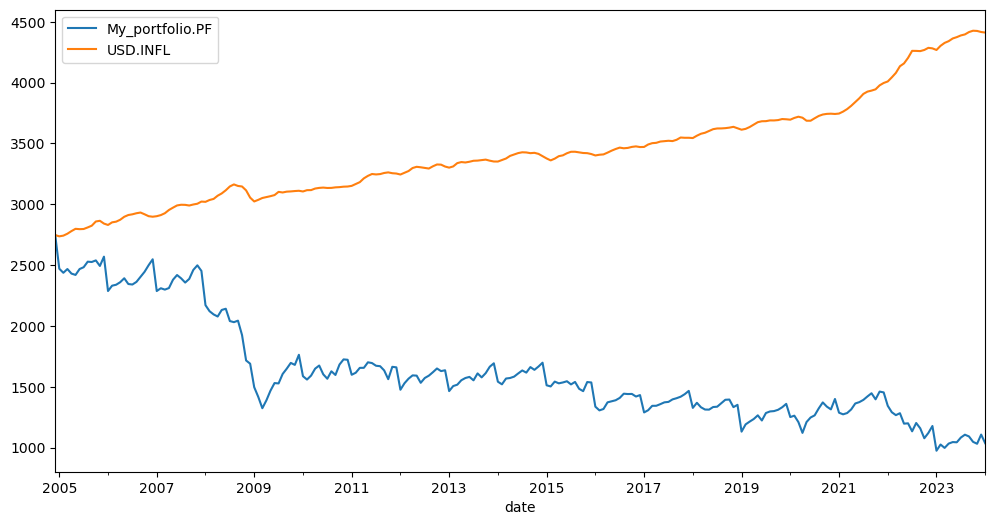

In [62]:
pf.dcf.wealth_index.plot()

This strategy significantly reduced the balance of the investment portfolio. However, it's not voided after almost 20 years.  
How many years such strategy can survive in the future?

### Monte Carlo simulation

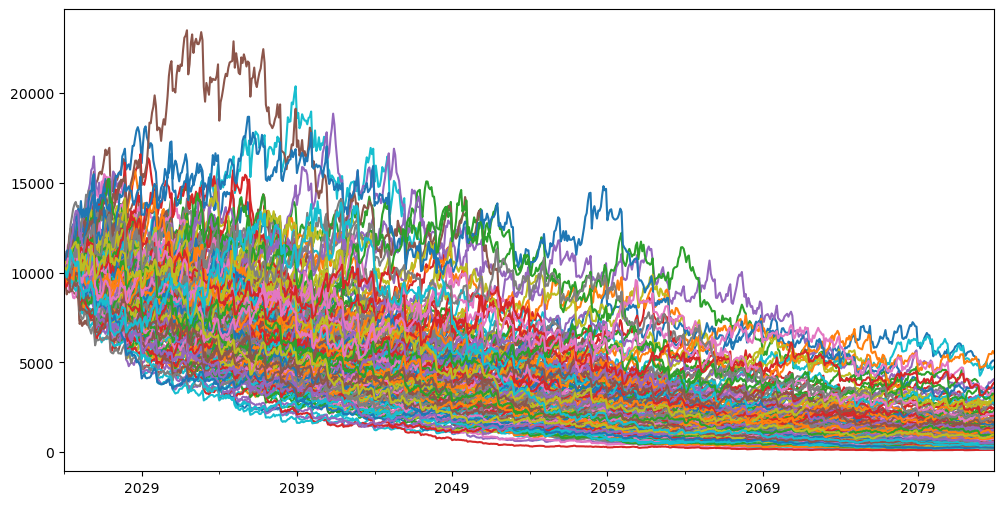

In [63]:
pf.dcf.plot_forecast_monte_carlo(backtest=False)

In fixed percentage strategy the balance never voids. It can be very small, but the strategy still will be able to withdraw the fixed percentage.   
`threshold` parameter helps to define when the balance is considered equal to zero.  
`threshold` is defined as a percentage of the initial investments when the portfolio balance considered voided.

In [64]:
s = pf.dcf.monte_carlo_survival_period(threshold=0.10)  # threshold is set to 10%

In [65]:
s.describe()

count    200.000000
mean      20.395000
std        3.907508
min       11.300000
25%       18.100000
50%       20.100000
75%       23.100000
max       30.100000
dtype: float64

Most scenarios (50th percentile) have positive balance for 30+ years. However in this scenario, portfolio withdrawals decrease each period as the balance declines.

What if our goal is to leave a legacy? We want to withdraw as much money from the portfolio as possible so that its purchasing power does not decrease. We can find the maximum withdrawal rate that meets these conditions, again using the `find_the_largest_withdrawals_size` method. The `goal` parameter should be changed to `maintain_balance`.  

But first we need to reduce the `period` in Monte Carlos settings. In the simulation the size of portfolio is considered at the end of period. Usually it should not be too long (30 years here).

In [66]:
pf.dcf.set_mc_parameters(
    distribution="norm",   
    period=30,   # simulation period in years 
    number=200  
)

It's important also to set enough intermediate steps (at least 40) in `find_the_largest_withdrawals_size` method to be able to find small enough percentage sizes. The algorithm goes through percentages from 100 to 0 with a step that is defined by the `withdrawal_steps`. If the number of steps is too small (for example 10), then the smallest percentage that will be considered is 10% (100 / 10).

In [67]:
pf.dcf.find_the_largest_withdrawals_size(
    withdrawal_steps=40,   # The number of intermediate steps during the iteration of values fom max to min of the withdrawal size
    confidence_level=0.25,  # Confidence level defines the percentile of Monte Carlo time series. The 25th percentile is a negative scenario.
    goal="maintain_balance",  # The goal of the strategy in this case is to keep the portfolio's real balance
)

0

In this example we see that annual withdrawals of 2,5% will help to maintain the portfolio balance (keep the purchasing power) after 30 years.  

## TimeSeriesStrategy: user-defined withdrawals and contributions

`TimeSeriesStrategy` helps to study scenarios with an arbitrary set of withdrawals and contributions. Their size and dates are specified by the user in the form of a dictionary.  
Let's create a new poerfolio with fixed first and last dates to define better the timeframe where we see the historical data.

In [68]:
pf2 = ok.Portfolio(first_date="2015-01", last_date="2024-10")  # create Portfolio with default ticker (SPY.US)
pf2

symbol                portfolio_1215.PF
assets                         [SPY.US]
weights                           [1.0]
rebalancing_period                month
currency                            USD
inflation                      USD.INFL
first_date                      2015-01
last_date                       2024-09
period_length         9 years, 9 months
dtype: object

Now we can create a simple dictionary with cash flow amounts and dates.

In [69]:
d = {
    "2018-02": 2_000,  # contribution
    "2024-03": -4_000  # withdrawal
}

Then we create `TimeSeresStrategy` linked to the portfolio and use the dictionary to set the cash flow.

In [70]:
ts = ok.TimeSeriesStrategy(pf2)
ts.time_series_dic = d  # use the dictionary to set cash flow

It's possible also to define initial investments. It's optional but usually some kind of investment occurs on the first date of the period.

In [71]:
ts.initial_investment = 1_000  # add initial investments size (optional)

Assign the cash flow strategy to portfolio.

In [72]:
pf2.dcf.cashflow_parameters = ts

### Backtest the Portfolio

The dates in the dictionary are in the past. Therefore this set of cash flows can be used for backtesting (for Monte Carlo we define another dictionary with the future dates).

<Axes: >

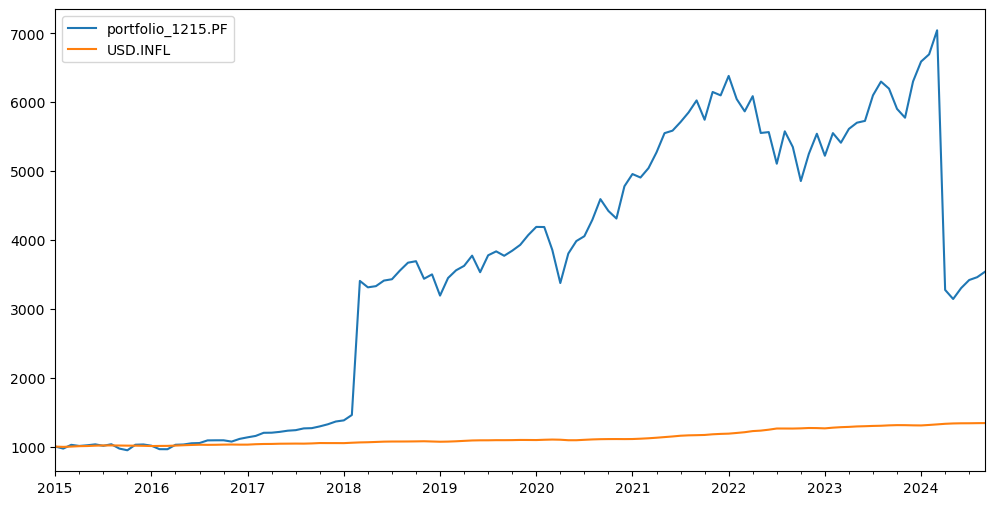

In [73]:
pf2.dcf.wealth_index.plot()

### Monte Carlo simulation

For Monte Carlo simulation we should define another dates in the future (or the simulation will test the strategy without cash flows).

In [74]:
d = {
    "2027-02": 2_000,  # contribution
    "2034-03": -4_000  # withdrawal
}

The most important event is large withdrawal in 2034. How likely is it that the portfolio balance will withstand this withdrawal?

Create the `TimeSeriesStrategy` and assign it to Portfolio. The initial investments in this scenario is 1,000. Then we add another 2,000 (3,000 in total) and hope to withdraw 4,000 in 2034.

In [75]:
ts2 = ok.TimeSeriesStrategy(pf2)
ts2.time_series_dic = d  # use the dictionary to set cash flow
ts2.initial_investment = 1_000
pf2.dcf.cashflow_parameters = ts2

Now we can test the future scenarios with Monte Carlo simulation after setting the parameters.

In [76]:
pf2.dcf.set_mc_parameters(
    distribution="norm",  # Normal distribution (or Gaussian distribution) 
    period=30,  # the forecasting period is 30 years
    number=500  # generate 500 random simulations
)

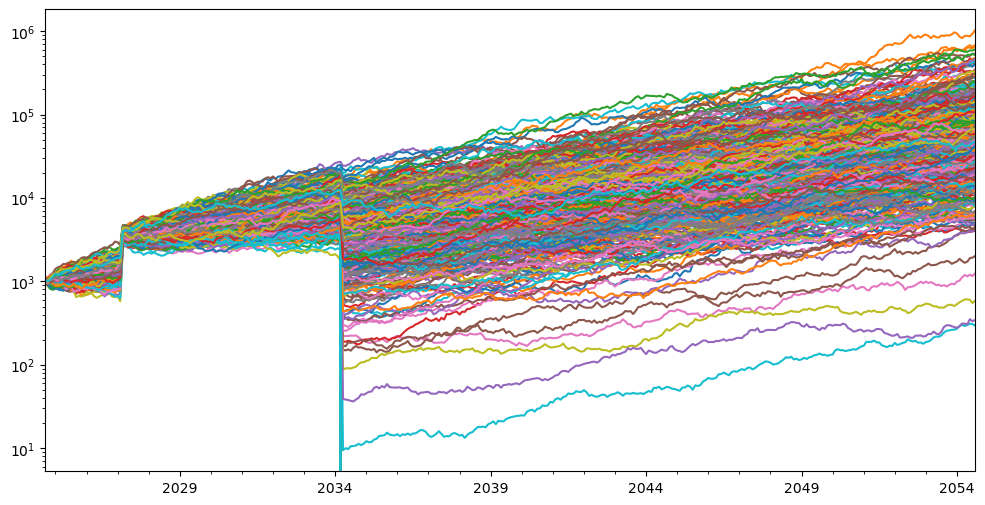

In [77]:
pf2.dcf.plot_forecast_monte_carlo(backtest=False)
plt.yscale("log")  # we use logarithmic scale to see better the negative scenarios

The chart shows that most scenarios are optimistic. The balance is reduced significantly, but many portfolios survive after 30 years test period.    

In [78]:
s = pf2.dcf.monte_carlo_survival_period(threshold=0.10)  # the balance is considered voided when it drops to 10%.

In [79]:
s.describe([0.05, 0.25, 0.50])

count    500.000000
mean      28.700800
std        4.973461
min        9.700000
5%         9.700000
25%       30.000000
50%       30.000000
max       30.000000
dtype: float64

Only in 5% of random scenarios the balance of portfolio is voided (reduced to 10% o below). The 25th and 50th shows that in most scenarios the portfolio is alive after 30 years. 